### Importing required packages

In [17]:
import tensorflow as tf
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D,Dropout,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer


### Loading data 

In [19]:
# Load the dataset from your folder

train = loadmat('train_32x32.mat')
test = loadmat('test_32x32.mat')

### Inspect and preprocess the dataset


In [20]:
X_train=train['X']/255.0
y_train=train['y']
X_train = np.moveaxis(X_train, -1, 0)
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
#y_train = to_categorical(np.array(y_train))
X_train = X_train.astype('float64')
y_train = y_train.astype('int64')


In [21]:
X_test=test['X']/255.0
y_test=test['y']
X_test = np.moveaxis(X_test, -1, 0)
y_test = lb.fit_transform(y_test)
X_test = X_test.astype('float64')
y_test = y_test.astype('int64')


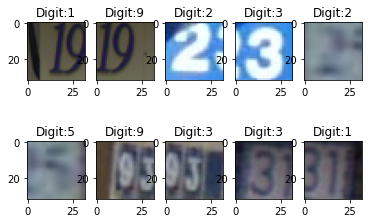

In [22]:
fig = plt.figure()
for i,x in enumerate(X_train[:10]):
  ax=fig.add_subplot(2, 5, i + 1)
  ax.title.set_text('Digit:{}'.format(int(train['y'][i])))
  plt.imshow(x)
plt.show()

In [23]:
X_train_grey=np.average(X_train,axis = 3)
X_train_grey.shape


(73257, 32, 32)

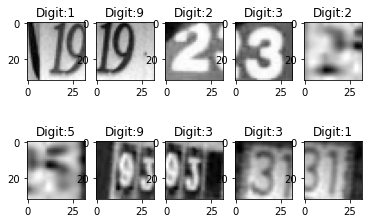

In [24]:
fig = plt.figure()
for i,x in enumerate(X_train_grey[:10]):
  ax=fig.add_subplot(2, 5, i + 1)
  ax.title.set_text('Digit:{}'.format(int(train['y'][i])))
  cmap=plt.get_cmap('gray')
  plt.imshow(x,cmap=cmap)
plt.show()

In [25]:
X_test_grey=np.average(X_test,axis = 3)
X_train_grey=X_train_grey.reshape(73257, 32, 32,1)
X_test_grey=X_test_grey.reshape(26032, 32, 32,1)


### MLP neural network classifier


In [45]:
mlp=Sequential()
mlp.add(Flatten(input_shape=(X_train_grey[0].shape)))
mlp.add(Dense(128,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)))
mlp.add(Dense(128,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)))
mlp.add(Dense(64,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)))
mlp.add(Dense(10,activation='softmax'))

In [46]:
mlp.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4),loss='categorical_crossentropy',metrics=['acc'])

In [47]:
mlp.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               131200    
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 10)                650       
Total params: 156,618
Trainable params: 156,618
Non-trainable params: 0
_________________________________________________________________


In [48]:
early=EarlyStopping(monitor='val_acc',mode='max',patience=3)

In [49]:
hist=mlp.fit(X_train_grey, y_train, epochs=30, validation_split=0.15, callbacks=[early],batch_size=32)
mlp.save('model_MLP.h5')

Epoch 1/30
1946/1946 [==============================] - 6s 3ms/step - loss: 2.3544 - acc: 0.2705 - val_loss: 2.0079 - val_acc: 0.4087
Epoch 2/30
1946/1946 [==============================] - 6s 3ms/step - loss: 1.7759 - acc: 0.4886 - val_loss: 1.6291 - val_acc: 0.5554
Epoch 3/30
1946/1946 [==============================] - 6s 3ms/step - loss: 1.5633 - acc: 0.5784 - val_loss: 1.5257 - val_acc: 0.5826
Epoch 4/30
1946/1946 [==============================] - 6s 3ms/step - loss: 1.4627 - acc: 0.6115 - val_loss: 1.4463 - val_acc: 0.6224
Epoch 5/30
1946/1946 [==============================] - 6s 3ms/step - loss: 1.3987 - acc: 0.6359 - val_loss: 1.3961 - val_acc: 0.6325
Epoch 6/30
1946/1946 [==============================] - 6s 3ms/step - loss: 1.3537 - acc: 0.6504 - val_loss: 1.3469 - val_acc: 0.6490
Epoch 7/30
1946/1946 [==============================] - 6s 3ms/step - loss: 1.3142 - acc: 0.6660 - val_loss: 1.3231 - val_acc: 0.6617
Epoch 8/30
1946/1946 [==============================] - 6s 3ms

### Visualize accuracy and loss 

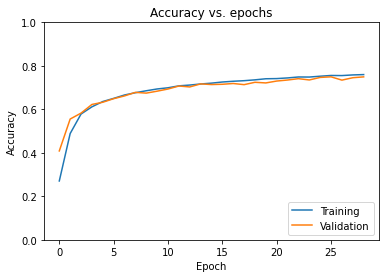

In [50]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

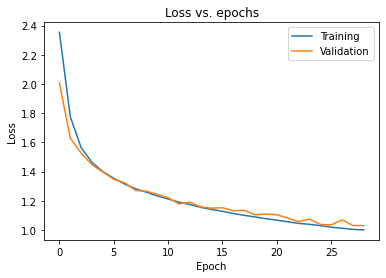

In [51]:
#Run this cell to plot the epoch vs loss graph
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

### Evaluate MLP Model

In [52]:
mlp.evaluate(X_test_grey,y_test)

814/814 [==============================] - 2s 2ms/step - loss: 1.1022 - acc: 0.7305


[1.1021980047225952, 0.7304855585098267]

### CNN neural network classifier


In [53]:
cnn=Sequential()
cnn.add(Conv2D(32,(3,3),activation='relu',input_shape=(X_train_grey[0].shape)))
cnn.add(MaxPooling2D(2,2))
cnn.add(Conv2D(16,(3,3),activation='relu',input_shape=(X_train_grey[0].shape)))
cnn.add(MaxPooling2D(2,2))
cnn.add(Conv2D(8,(3,3),activation='relu',input_shape=(X_train_grey[0].shape)))
cnn.add(MaxPooling2D(2,2))
cnn.add(Flatten(input_shape=(X_train_grey[0].shape)))
cnn.add(Dense(64,activation='relu'))
cnn.add(BatchNormalization())
cnn.add(Dense(64,activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(Dense(10,activation='softmax'))

In [54]:
cnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 16)        4624      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 16)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 8)           1160      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 2, 2, 8)           0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 32)               

In [55]:
cnn.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-4),loss='categorical_crossentropy',metrics=['acc'])

In [56]:
early=EarlyStopping(monitor='loss',mode='min',patience=3,min_delta=0.001)

In [57]:
hist=cnn.fit(X_train_grey, y_train, epochs=30, validation_split=0.15, callbacks=[early],batch_size=32)
cnn.save('model_CNN.h5')

Epoch 1/30
1946/1946 [==============================] - 9s 5ms/step - loss: 1.8124 - acc: 0.3749 - val_loss: 1.2556 - val_acc: 0.5950
Epoch 2/30
1946/1946 [==============================] - 8s 4ms/step - loss: 1.1411 - acc: 0.6292 - val_loss: 0.9644 - val_acc: 0.6941
Epoch 3/30
1946/1946 [==============================] - 9s 5ms/step - loss: 0.9371 - acc: 0.7030 - val_loss: 0.9512 - val_acc: 0.6908
Epoch 4/30
1946/1946 [==============================] - 9s 5ms/step - loss: 0.8428 - acc: 0.7345 - val_loss: 0.7697 - val_acc: 0.7577
Epoch 5/30
1946/1946 [==============================] - 9s 4ms/step - loss: 0.7778 - acc: 0.7561 - val_loss: 0.6957 - val_acc: 0.7808
Epoch 6/30
1946/1946 [==============================] - 9s 5ms/step - loss: 0.7375 - acc: 0.7694 - val_loss: 0.6629 - val_acc: 0.7942
Epoch 7/30
1946/1946 [==============================] - 9s 4ms/step - loss: 0.7078 - acc: 0.7797 - val_loss: 0.6388 - val_acc: 0.8058
Epoch 8/30
1946/1946 [==============================] - 9s 5ms

### Visualise accuracy and loss

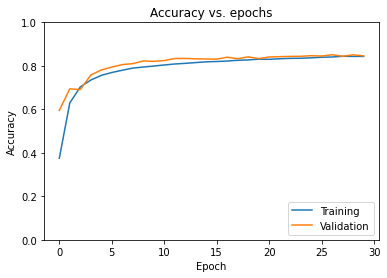

In [58]:
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim(0,1)
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

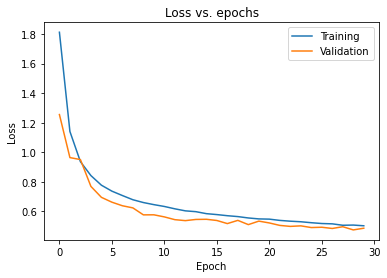

In [59]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show() 

### Evaluate CNN model 

In [60]:
cnn.evaluate(X_test_grey,y_test)

814/814 [==============================] - 2s 3ms/step - loss: 0.4972 - acc: 0.8463


[0.497196763753891, 0.8462661504745483]

### Get model predictions


In [61]:
sample_images=X_test_grey.reshape(26032,32,32)
num_test_images = X_test_grey.shape[0]
random_inx = np.random.choice(num_test_images, 5)
random_test_images = sample_images[random_inx, ...]
random_test_labels = y_test[random_inx, ...]


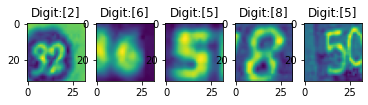

In [62]:
fig = plt.figure()
for i,x in enumerate(random_test_images):
  ax=fig.add_subplot(1, 5, i + 1)
  ax.title.set_text('Digit:{}'.format(test['y'][random_inx[i]]))
  plt.imshow(x)
plt.show()


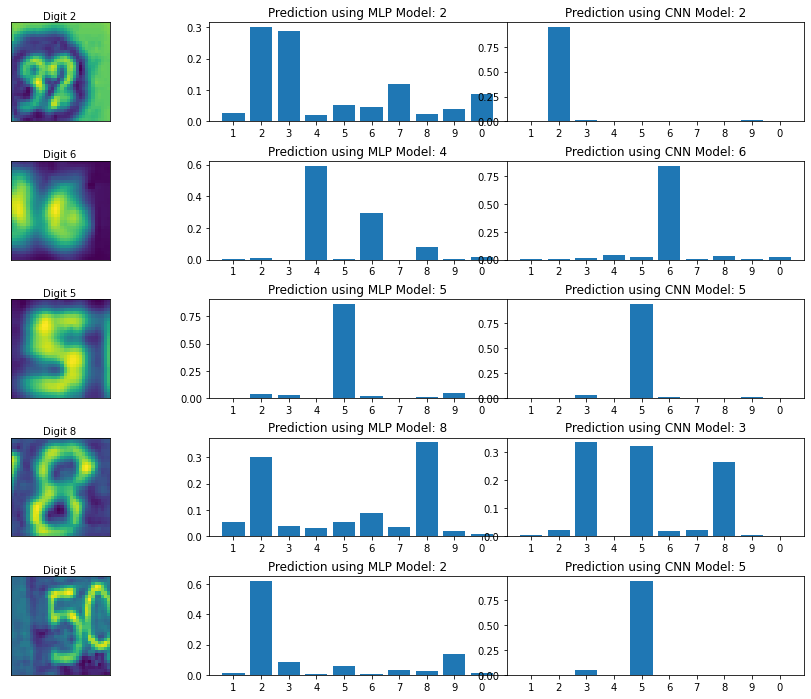

In [64]:
random_test_images = X_test_grey[random_inx, ...]
random_test_labels = test['y'][random_inx, ...]

predcnn = cnn.predict(random_test_images)
predmlp = mlp.predict(random_test_images)

fig, axes = plt.subplots(5, 3, figsize=(16, 12))
fig.subplots_adjust(hspace=0.4, wspace=0)

for i, (predcnn,predmlp, image, label) in enumerate(zip(predcnn,predmlp, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(10., -1.5, f'Digit {int(label)}')
    axes[i, 1].bar([0,1,2,3,4,5,6,7,8,9], predmlp)
    axes[i, 2].bar(np.arange(len(predcnn)), predcnn)
    axes[i, 1].set_xticks(np.arange(len(predmlp)))
    axes[i, 2].set_xticks(np.arange(len(predcnn)))
    axes[i, 1].set_xticklabels([1,2,3,4,5,6,7,8,9,0])
    axes[i, 2].set_xticklabels([1,2,3,4,5,6,7,8,9,0])
    axes[i, 1].set_title(f"Prediction using MLP Model: {np.argmax(predmlp)+1}")
    axes[i, 2].set_title(f"Prediction using CNN Model: {np.argmax(predcnn)+1}")
    
plt.show()